In [1]:
using Interpolations
using Dierckx
using NPZ
using DifferentialEquations
using Plots
using PyPlot 
import PyPlot
using LaTeXStrings
using Statistics
using PyCall
using ScatteredInterpolation
using FFTW

┌ Info: Precompiling ScatteredInterpolation [3f865c0f-6dca-5f4d-999b-29fe1e7e3c92]
└ @ Base loading.jl:1278


In [2]:
pxr = pyimport("pixie_read_st")

PyObject <module 'pixie_read_st' from '/users/giannis_kx/python_pixie/pixie_read_st.py'>

In [3]:
filepath = "/net/scratch3/giannis_kx/pixie3d/iter/iter3d/db_tear/dt_sh_m3_n2.scratch/pixie3d.h5"

"/net/scratch3/giannis_kx/pixie3d/iter/iter3d/db_tear/dt_sh_m3_n2.scratch/pixie3d.h5"

In [4]:
pxr.pixieload(filepath)

In [5]:
psi = pxr.load_array(3,4,150,152);
B1 = pxr.load_array(1,0,150,152);
B2 = pxr.load_array(1,1,150,152);
B3 = pxr.load_array(1,2,150,152);

In [6]:
B_1 = pxr.load_array(2,0,150,152);
B_2 = pxr.load_array(2,1,150,152);
B_3 = pxr.load_array(2,2,150,152);

In [7]:
psit = dropdims(mean(psi,dims=3),dims=3);
B1t = dropdims(mean(B1,dims=3),dims=3);
B2t = dropdims(mean(B2,dims=3),dims=3);
B3t = dropdims(mean(B3,dims=3),dims=3);

In [8]:
B_1t = dropdims(mean(B_1,dims=3),dims=3);
B_2t = dropdims(mean(B_2,dims=3),dims=3);
B_3t = dropdims(mean(B_3,dims=3),dims=3);

In [9]:
JBpc = sqrt.((B1.*B_1) .+ (B2.*B_2));

In [10]:
JBpco = sqrt.((B1t.*B_1t) .+ (B2t.*B_2t));

In [11]:
# definitions of cell grid
num_r_cells = size(B3)[1];
num_u_cells = size(B3)[2];
num_phi_cells = size(B3)[3];
dn_r = (1.0/num_r_cells);
dn_u = ((2.0*pi)/num_u_cells);

# Cell-based grid
rc = LinRange(0.0+(dn_r/2.0),1.0-(dn_r/2.0),num_r_cells);
uc = LinRange(0.0+(dn_u/2.0),2.0*pi-(dn_u/2.0),num_u_cells);
phic = LinRange(0.0+(dn_u/2.0),2.0*pi-(dn_u/2.0),num_phi_cells);
tn = LinRange(0, size(B3)[4]-1,size(B3)[4]);

# Node-based grid
rn = LinRange(0.0,1.0,(num_r_cells+1));
un = LinRange(0.0,2.0*pi,(num_u_cells+1));
phin = LinRange(0.0,2.0*pi,(num_phi_cells+1));

# Node-based grid dimensions
rdim = size(psi)[1];
udim = size(psi)[2];
fidim = size(psi)[3];
tdim = size(psi)[4];
psidim = 101;
ufdim = udim; # ufdim same as udim to avoid aliasing

# Straight field line coordinate grid
pn = LinRange(0.0,1.0,psidim);
ufn = LinRange(0.0,2.0*pi,ufdim);

In [12]:
B1_int = Interpolations.interpolate(B1,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Line(OnGrid())))));
B2_int = Interpolations.interpolate(B2,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Line(OnGrid())))));
B3_int = Interpolations.interpolate(B3,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Line(OnGrid())))));
B1t_int = Interpolations.interpolate(B1t,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Line(OnGrid())))));
B2t_int = Interpolations.interpolate(B2t,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Line(OnGrid())))));
B3t_int = Interpolations.interpolate(B3t,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Line(OnGrid())))));

In [13]:
B_1_int = Interpolations.interpolate(B_1,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Line(OnGrid())))));
B_2_int = Interpolations.interpolate(B_2,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Line(OnGrid())))));
B_3_int = Interpolations.interpolate(B_3,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Line(OnGrid())))));
B_1t_int = Interpolations.interpolate(B_1t,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Line(OnGrid())))));
B_2t_int = Interpolations.interpolate(B_2t,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Line(OnGrid())))));
B_3t_int = Interpolations.interpolate(B_3t,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Line(OnGrid())))));

In [14]:
JBpc_int = Interpolations.interpolate(JBpc,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Line(OnGrid())))));
JBpco_int = Interpolations.interpolate(JBpco,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Line(OnGrid())))));

In [15]:
B1_sint = scale(B1_int,rc,uc,phic,tn);
B2_sint = scale(B2_int,rc,uc,phic,tn);
B3_sint = scale(B3_int,rc,uc,phic,tn);
B1t_sint = scale(B1t_int,rc,uc,tn);
B2t_sint = scale(B2t_int,rc,uc,tn);
B3t_sint = scale(B3t_int,rc,uc,tn);

In [16]:
B_1_sint = scale(B_1_int,rc,uc,phic,tn);
B_2_sint = scale(B_2_int,rc,uc,phic,tn);
B_3_sint = scale(B_3_int,rc,uc,phic,tn);
B_1t_sint = scale(B_1t_int,rc,uc,tn);
B_2t_sint = scale(B_2t_int,rc,uc,tn);
B_3t_sint = scale(B_3t_int,rc,uc,tn);

In [17]:
JBpc_sint = scale(JBpc_int,rc,uc,phic,tn);
JBpco_sint = scale(JBpco_int,rc,uc,tn);

In [18]:
B1_eint = extrapolate(B1_sint, (Line(),Periodic(),Periodic(),Line()));
B2_eint = extrapolate(B2_sint, (Line(),Periodic(),Periodic(),Line()));
B3_eint = extrapolate(B3_sint, (Line(),Periodic(),Periodic(),Line()));
B1t_eint = extrapolate(B1t_sint, (Line(),Periodic(),Line()));
B2t_eint = extrapolate(B2t_sint, (Line(),Periodic(),Line()));
B3t_eint = extrapolate(B3t_sint, (Line(),Periodic(),Line()));

In [19]:
B_1_eint = extrapolate(B_1_sint, (Line(),Periodic(),Periodic(),Line()));
B_2_eint = extrapolate(B_2_sint, (Line(),Periodic(),Periodic(),Line()));
B_3_eint = extrapolate(B_3_sint, (Line(),Periodic(),Periodic(),Line()));
B_1t_eint = extrapolate(B_1t_sint, (Line(),Periodic(),Line()));
B_2t_eint = extrapolate(B_2t_sint, (Line(),Periodic(),Line()));
B_3t_eint = extrapolate(B_3t_sint, (Line(),Periodic(),Line()));

In [20]:
JBpc_eint = extrapolate(JBpc_sint, (Line(),Periodic(),Periodic(),Line()));
JBpco_eint = extrapolate(JBpco_sint, (Line(),Periodic(),Line()));

In [21]:
B1 = B1_eint(rn,un,phin,tn);
B2 = B2_eint(rn,un,phin,tn);
B3 = B3_eint(rn,un,phin,tn);
B1t = B1t_eint(rn,un,tn);
B2t = B2t_eint(rn,un,tn);
B3t = B3t_eint(rn,un,tn);

In [22]:
B_1 = B_1_eint(rn,un,phin,tn);
B_2 = B_2_eint(rn,un,phin,tn);
B_3 = B_3_eint(rn,un,phin,tn);
B_1t = B_1t_eint(rn,un,tn);
B_2t = B_2t_eint(rn,un,tn);
B_3t = B_3t_eint(rn,un,tn);

In [23]:
JBp = JBpc_eint(rn,un,phin,tn);
JBpo = JBpco_eint(rn,un,tn);

In [24]:
X_int = Interpolations.interpolate(pxr.X,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid())))));
Z_int = Interpolations.interpolate(pxr.Z,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid())))));
psi_int = Interpolations.interpolate(psi,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
B1_int = Interpolations.interpolate(B1,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
B2_int = Interpolations.interpolate(B2,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
B3_int = Interpolations.interpolate(B3,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
B1t_int = Interpolations.interpolate(B1t,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
B2t_int = Interpolations.interpolate(B2t,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
B3t_int = Interpolations.interpolate(B3t,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));

In [25]:
B_1_int = Interpolations.interpolate(B_1,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
B_2_int = Interpolations.interpolate(B_2,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
B_3_int = Interpolations.interpolate(B_3,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
B_1t_int = Interpolations.interpolate(B_1t,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
B_2t_int = Interpolations.interpolate(B_2t,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
B_3t_int = Interpolations.interpolate(B_3t,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));

In [26]:
JBp_int = Interpolations.interpolate(JBp,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
JBpo_int = Interpolations.interpolate(JBpo,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));

In [27]:
# Rescaling interpolation intervals
X_sint = scale(X_int, rn,un,phin);
Z_sint = scale(Z_int, rn,un,phin);
psi_sint = scale(psi_int, rn,un,phin,tn);
B1_sint = scale(B1_int, rn,un,phin,tn);
B2_sint = scale(B2_int, rn,un,phin,tn);
B3_sint = scale(B3_int, rn,un,phin,tn);
B1t_sint = scale(B1t_int, rn,un,tn);
B2t_sint = scale(B2t_int, rn,un,tn);
B3t_sint = scale(B3t_int, rn,un,tn);

In [28]:
B_1_sint = scale(B_1_int, rn,un,phin,tn);
B_2_sint = scale(B_2_int, rn,un,phin,tn);
B_3_sint = scale(B_3_int, rn,un,phin,tn);
B_1t_sint = scale(B_1t_int, rn,un,tn);
B_2t_sint = scale(B_2t_int, rn,un,tn);
B_3t_sint = scale(B_3t_int, rn,un,tn);

In [29]:
JBp_sint = scale(JBp_int, rn,un,phin,tn);
JBpo_sint = scale(JBpo_int, rn,un,tn);

In [30]:
# Extrapolations on rescaled
X_eint = extrapolate(X_sint, (Line(),Periodic(),Periodic()));
Z_eint = extrapolate(Z_sint, (Line(),Periodic(),Periodic()));
psi_eint = extrapolate(psi_sint, (Line(),Periodic(),Periodic(),Line()));
B1_eint = extrapolate(B1_sint, (Line(),Periodic(),Periodic(),Line()));
B2_eint = extrapolate(B2_sint, (Line(),Periodic(),Periodic(),Line()));
B3_eint = extrapolate(B3_sint, (Line(),Periodic(),Periodic(),Line()));
B1t_eint = extrapolate(B1t_sint, (Line(),Periodic(),Line()));
B2t_eint = extrapolate(B2t_sint, (Line(),Periodic(),Line()));
B3t_eint = extrapolate(B3t_sint, (Line(),Periodic(),Line()));

In [31]:
B_1_eint = extrapolate(B_1_sint, (Line(),Periodic(),Periodic(),Line()));
B_2_eint = extrapolate(B_2_sint, (Line(),Periodic(),Periodic(),Line()));
B_3_eint = extrapolate(B_3_sint, (Line(),Periodic(),Periodic(),Line()));
B_1t_eint = extrapolate(B_1t_sint, (Line(),Periodic(),Line()));
B_2t_eint = extrapolate(B_2t_sint, (Line(),Periodic(),Line()));
B_3t_eint = extrapolate(B_3t_sint, (Line(),Periodic(),Line()));

In [32]:
JBp_eint = extrapolate(JBp_sint, (Line(),Periodic(),Periodic(),Line()));
JBpo_eint = extrapolate(JBpo_sint, (Line(),Periodic(),Line()));

## Evaluate n=0 component of perturbed flux

In [33]:
na = [CartesianIndex()];

In [34]:
dB1 = B1.-B1t[:,:,na,:];
dB2 = B2.-B2t[:,:,na,:];    
dB3 = B3.-B3t[:,:,na,:];

In [35]:
brho = dB1.*B2t[:,:,na,:] .- dB2.*B1t[:,:,na,:];
b_hat_rho = brho./B3t[:,:,na,:];

In [38]:
b_hat_rho[11,21,6,1]

0.00048141719527801835

In [39]:
FdB1 = fft(dB1,[3]);

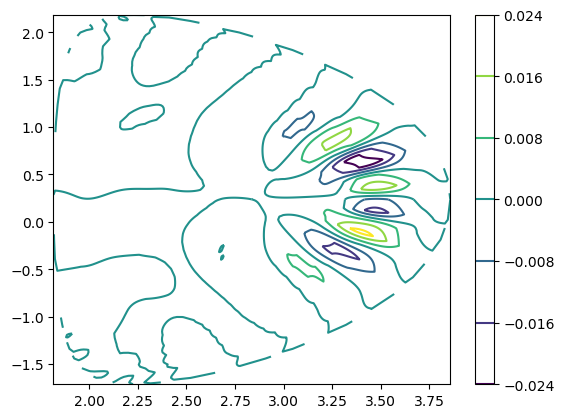

In [43]:
PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],FdB1[:,:,1,1])
PyPlot.colorbar()
PyPlot.show()

In [64]:
B1calc = B1[:,:,:,1];

In [65]:
B1tcalc = dropdims(mean(B1calc,dims=3),dims=3);

In [66]:
dB1calc = B1calc.-B1tcalc[:,:,na];

In [67]:
FdB1calc = fft(dB1calc,[3]);

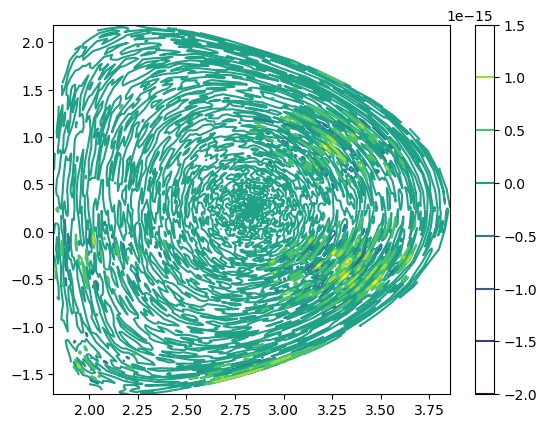

In [71]:
PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],FdB1calc[:,:,1])
PyPlot.colorbar()
PyPlot.show()

In [72]:
B1tcalc2 = dropdims(mean(B1,dims=3),dims=3);

In [76]:
println(B1tcalc[32,32])
println(B1tcalc2[32,32,1])

0.010343289444786812
0.010343289444786812


In [83]:
dB1calc2 = B1.-B1tcalc2[:,:,na,:];

In [86]:
println(dB1calc[32,32,8])
println(dB1calc2[32,32,8,1])

-0.001790113228658713
-0.001790113228658713


In [87]:
FdB1calc2 = fft(dB1calc2,[3]);

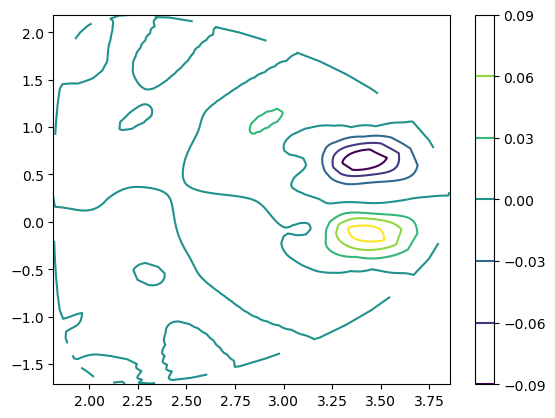

In [89]:
PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],FdB1calc2[:,:,2,1])
PyPlot.colorbar()
PyPlot.show()

In [90]:
B2tcalc2 = dropdims(mean(B2,dims=3),dims=3);
B3tcalc2 = dropdims(mean(B3,dims=3),dims=3);

In [91]:
dB2calc2 = B2.-B2tcalc2[:,:,na,:];
dB3calc2 = B3.-B3tcalc2[:,:,na,:];

In [93]:
size(B2tcalc2)

(129, 65, 2)

In [94]:
brho = dB1calc2.*B2tcalc2[:,:,na,:].-dB2calc2.*B1tcalc2[:,:,na,:];

In [100]:
b_hat_rho = brho./B3tcalc2[:,:,na,:];

In [101]:
Fbrho = fft(b_hat_rho,[3]);

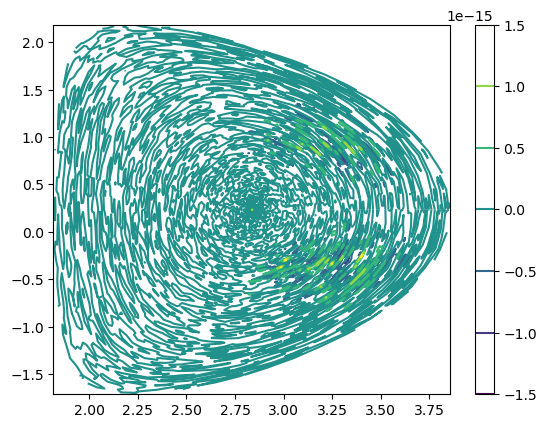

In [105]:
PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],Fbrho[:,:,1,1])
PyPlot.colorbar()
PyPlot.show()

In [108]:
println(b_hat_rho[12,12,1,1])
println(b_hat_rho[12,12,2,1])

-0.00041622670667933626
-0.0002802940866086492


In [112]:
mean(b_hat_rho[12,2,:,1])

8.562733066788927e-20

In [210]:
function Flux_surface!(du,u,p,t)
    du[1] = B1t_eint(u[1],u[2],p[1])/JBpo_eint(u[1],u[2],p[1])
    du[2] = B2t_eint(u[1],u[2],p[1])/JBpo_eint(u[1],u[2],p[1])
    du[3] = B3t_eint(u[1],u[2],p[1])/JBpo_eint(u[1],u[2],p[1])
    end


function condition(u,t,integrator)
    abs(u[2]) - 2*pi 
end

function condition_zero(u,t,integrator)
    u[2] - 0.0
end

function condition_crossing(u,t,integrator)
    integrator.p[2] == 2.0
end 

function affect_cross!(integrator)
    integrator.p[2] = integrator.p[2]+1
end


function affect!(integrator)
    terminate!(integrator)
end

cb1 = ContinuousCallback(condition,affect!,rootfind = true)
cb2 = ContinuousCallback(condition_zero,affect_cross!,rootfind = true)
cb3 = DiscreteCallback(condition_crossing,affect!)

function monitor(integrator)
    for (t,u) in tuples(integrator)
        @show t,u
    end
end

"""Solver call"""
function fs_integration(rs::Float64,us::Float64,time::Int)
    u0 = [rs,us,0.0]
    p = [time,0]
    tspan = (0.0,180.0)
    prob = ODEProblem(Flux_surface!,u0,tspan,p)
    cbs = CallbackSet(cb1,cb2,cb3)
    integrator = init(prob,Vern9(),callback=cbs,reltol=1.e-10,abstol=1.e-10)
    sol = solve(prob,Vern9(),callback=cbs,reltol=1.e-10,abstol=1.e-10)
    return sol
end

fs_integration

In [155]:
pxr.Axes_of_Interpolation(B3)
pxr.Grid_Interpolations(psit,B1,B2,B3)
pxr.Calculation_of_Units_and_Sizes()

In [156]:
psi_min,norm = pxr.Normalization_numbers(psit,B1t,B2t);

In [157]:
r_of_psi = pxr.create_r_psi_list(psit,B1t,B2t);

In [158]:
r_of_psi_array = r_of_psi[1];
rmaxis = r_of_psi[2];
umaxis = r_of_psi[3];

In [159]:
psi_min_ind = 2;
psi_max_ind = 100;
psi_range = psi_max_ind-psi_min_ind+1;

In [160]:
rn[2]

0.0078125

In [161]:
r_of_psi_array[1,1]

0.07031599684254258

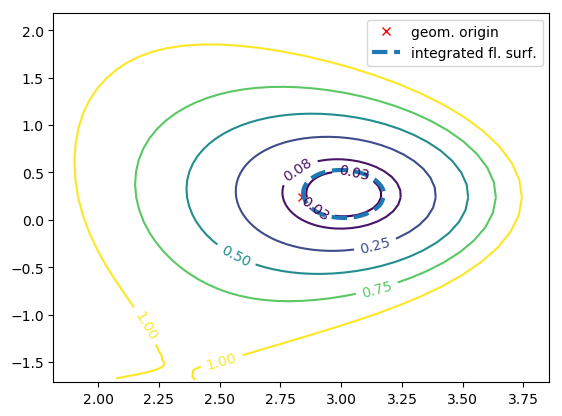

In [163]:
t = 1
#sol = fs_integration(r_of_psi_array[t,100],0.0,t-1);
sol = fs_integration(rn[2],0.0,t-1);
xsol = [X_eint(sol[1,i],sol[2,i],0) for i in 1:length(sol.t)];
zsol = [Z_eint(sol[1,i],sol[2,i],0) for i in 1:length(sol.t)];
CS = PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],(psi[:,:,1,t].-psi_min[t])/(norm[t].-psi_min[t]),levels=[0.03,0.08,0.25,0.5,0.75,1.0])
PyPlot.clabel(CS,fmt="%1.2f")
PyPlot.plot(pxr.X[1,1,1],pxr.Z[1,1,1],"rx",label="geom. origin")
PyPlot.plot(xsol,zsol,linestyle="--",linewidth=3.0,label="integrated fl. surf.")
#PyPlot.xlim(1.6,1.8)
#PyPlot.ylim(-0.2,0.2)
PyPlot.legend()
PyPlot.show()

In [164]:
function inverse_dict()
    u_pts = LinRange(0.0,2*pi,udim)
    Inv_Dict = Dict{Tuple{Int64,Float64,Float64},Float64}()
    for t in range(0, stop=tdim-1)
        for r in rn[2:end]
            if r < r_of_psi_array[t+1,100]
                sol = fs_integration(r,0.0,t)
                u_sol = sol[2,:]
                uf_sol = sol[3,:]
                q_redef = last(sol[3,length(sol.t)])/(2.0*pi)
                uf_rsc = uf_sol/q_redef
                l = sol.t
                l_of_u = Spline1D(sort!(u_sol[1:end-1]),l[1:end-1],k=3,bc="extrapolate",s=1e-1)
                ls = l_of_u(u_pts)
                uf = sol(ls,idxs=3)
                for j in 1:udim
                    Inv_Dict[(t,r,u_pts[j])] = (uf[j])
                end
            else 
                for j in 1:udim
                    Inv_Dict[(t,r,u_pts[j])] = 0.0
                end
            end
        end
    end
    return Inv_Dict
end         

inverse_dict (generic function with 1 method)

In [165]:
Inv = inverse_dict()

Dict{Tuple{Int64,Float64,Float64},Float64} with 16640 entries:
  (0, 0.21875, 4.81056)     => 14.512
  (0, 0.03125, 2.65072)     => 11.2523
  (1, 0.90625, 3.92699)     => 0.0
  (1, 0.976562, 1.47262)    => 0.0
  (1, 0.539062, 5.69414)    => 9.33098
  (0, 0.078125, 2.15984)    => 12.0223
  (1, 0.1875, 4.90874)      => 16.5837
  (0, 0.789062, 5.79231)    => 20.537
  (0, 0.257812, 1.27627)    => 12.4227
  (0, 0.726562, 6.18501)    => 15.001
  (1, 0.5625, 4.12334)      => 9.42935
  (1, 0.84375, 4.71239)     => 30.223
  (1, 0.226562, 4.51604)    => 14.0084
  (1, 0.125, 0.19635)       => 10.814
  (0, 0.601562, 5.49779)    => 9.36808
  (1, 0.117188, 4.81056)    => 13.7966
  (0, 0.65625, 3.73064)     => 11.4755
  (1, 0.1875, 5.98866)      => 16.5837
  (1, 0.554688, 0.0981748)  => 9.37982
  (0, 0.90625, 1.47262)     => 0.0
  (0, 0.945312, 4.61421)    => 0.0
  (1, 0.0859375, 0.0981748) => 6.96553
  (1, 0.445312, 2.55254)    => 9.82878
  (1, 0.632812, 5.98866)    => 10.7075
  (1, 0.0078125, 0.098

In [166]:
function uf_array()
    ArrP = []
    u_pts = LinRange(0.0,2*pi,udim)
    for t in 1:tdim
        for r in rn[1:end]
            for u in u_pts
                if r == 0.0
                    uf = Inv[Int64(t-1),rn[2],0.0]
                    append!(ArrP,uf)
                #    r = rmaxis[t]
                #    u = umaxis[t]
                #    ArrVal = arr_eint(r,u,phi,t-1)
                #    append!(ArrP,ArrVal)
                else
                    uf = Inv[Int64(t-1),r,u]
                    #u = GD[Int64(t-1),round(p,digits=2),Float64(uf)][2]
                    #ArrVal = arr_eint(r,u,phi,t-1)
                    append!(ArrP,uf)
                end
            end
        end
    end
    Arr = permutedims(reshape(ArrP,size(u_pts)[1],size(rn)[1],tdim),(2,1,3))
    return Arr
end

uf_array (generic function with 1 method)

In [167]:
A = uf_array();

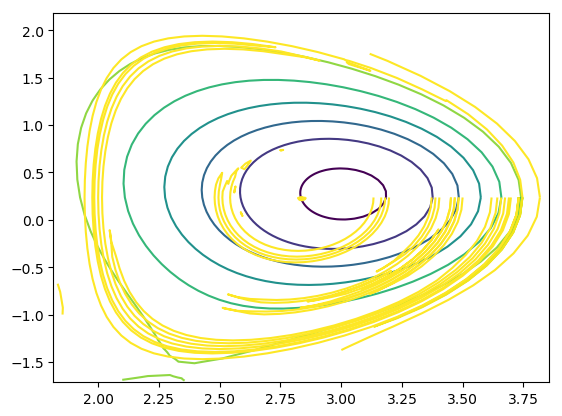

In [168]:
PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],psi[:,:,1,1])
PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],A[:,:,1],50)
PyPlot.show()

In [169]:
function uf_lists()
    r_list = []
    u_list = []
    uf_list = []
    
    u_pts = LinRange(0.0,2*pi,udim)
    t=0
    #for t in range(0, stop=tdim-1)
    for (i,r) in enumerate(r_of_psi_array[t+1,psi_min_ind:psi_max_ind])
        sol = fs_integration(r,0.0,t)
        u_sol = sol[2,:]
        uf_sol = sol[3,:]
        q_redef = last(sol[3,length(sol.t)])/(2.0*pi)
        uf_rsc = uf_sol/q_redef
        l = sol.t
            #l_of_u = Spline1D(sort!(u_sol[1:end-1]),l[1:end-1],k=3,bc="extrapolate",s=1e-1)
            #ls = l_of_u(u_pts)
            #triplet = sol(ls)
        L = length(l)
        for i in 1:L
            append!(r_list,sol[1,i])
            append!(u_list,sol[2,i])
            append!(uf_list,sol[3,i])
        end
    end
    return r_list,u_list,uf_list
end         

uf_lists (generic function with 1 method)

In [170]:
r_list,u_list,uf_list = uf_lists()

(Any[0.2620945066078568, 0.25959950184790637, 0.2557042089408715, 0.25198906794327985, 0.25003906739573956, 0.24833163891891552, 0.24487701467081702, 0.2385759968914432, 0.23406917576680014, 0.22799249441544467  …  0.8750548340189184, 0.8784426584355629, 0.8814720586901876, 0.8830884012812902, 0.8838147048590875, 0.8842496154225199, 0.8846609202766488, 0.884516706123006, 0.8844799169802064, 0.8844799169802064], Any[0.0, -0.029530525927493334, -0.06390409332453273, -0.08903901959884816, -0.10051095558947563, -0.10987883015254607, -0.1273625273581801, -0.15560679093826577, -0.17369883098714814, -0.19595775215319747  …  -6.022692801069721, -6.0729819393914575, -6.127402446550726, -6.16464615028466, -6.186623466952109, -6.20438813508106, -6.2590544587073484, -6.2794684878794715, -6.2831853071795845, -6.2831853071795845], Any[0.0, 0.20718437049536806, 0.4504963701290221, 0.6298579075329443, 0.7123022644444441, 0.7799815985254116, 0.9073479732139564, 1.1168344861930117, 1.2541550012651461, 1

In [171]:
A = cat(dims=2,r_list,u_list)
ufl = Float64.(uf_list);
rupoints = Float64.(A');

In [172]:
itp = ScatteredInterpolation.interpolate(ThinPlate(),rupoints,ufl,smooth=0.8)

ScatteredInterpolation.RBFInterpolant{Array{Float64,1},Array{Float64,2},Polyharmonic{Int64},Distances.Euclidean}([-8.551900850776374, -6.925172045120084, -5.055070425810235, -3.864018240148361, -3.3891707546854244, -3.0359796840708313, -2.4564135979468227, -1.7138675282190678, -1.345678719021345, -0.9872537559455016  …  6.8504696135339485, 7.032784035545486, 7.1159300327764825, 7.103075752714818, 7.112314942385882, 7.145270728029144, 7.274595777831162, 7.354633680726136, 7.379985538911, 7.379985538911002], [0.2620945066078568 0.25959950184790637 … 0.8844799169802064 0.8844799169802064; 0.0 -0.029530525927493334 … -6.2831853071795845 -6.2831853071795845], Polyharmonic{Int64}(2), Distances.Euclidean(0.0))

In [173]:
ufarr = []
for r in rn
    for u in un
        uf = ScatteredInterpolation.evaluate(itp,[r,u])
        append!(ufarr,uf)
    end
end
ufarr = permutedims(reshape(ufarr,size(un)[1],size(rn)[1]),(2,1));

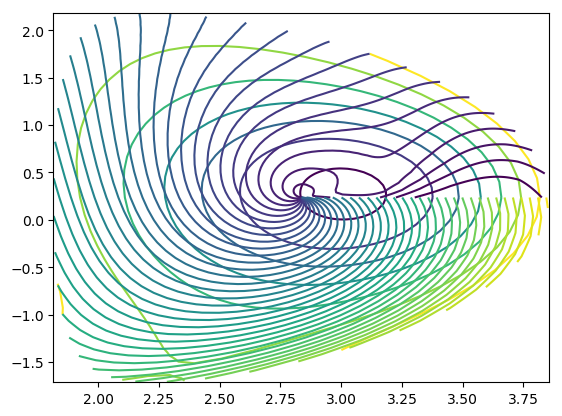

In [174]:
PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],psi[:,:,1,1])
PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],ufarr[:,:],50)
PyPlot.show()

In [175]:
x=0.01
spl = try
    Spline2D(r_list,u_list,uf_list,s=x)
catch
    try
        x = 2*x
        Spline2D(r_list,u_list,uf_list,s=x)
    catch
    end
end

In [66]:
uf_array = Dierckx.evalgrid(spl,rn,un);

LoadError: [91mMethodError: no method matching evalgrid(::Nothing, ::LinRange{Float64}, ::LinRange{Float64})[39m
[91m[0mClosest candidates are:[39m
[91m[0m  evalgrid([91m::Spline2D[39m, ::AbstractArray{T,1} where T, ::AbstractArray{T,1} where T) at /users/giannis_kx/.julia/packages/Dierckx/0w6mc/src/Dierckx.jl:978[39m

## $\frac{\delta B_p}{B_p (n=0)}$

In [215]:
na = CartesianIndex();

In [219]:
dBp = JBp[:,:,1,1] .- JBpo[:,:,1];

In [220]:
dBp_ov_Bp = dBp./JBpo[:,:,1];

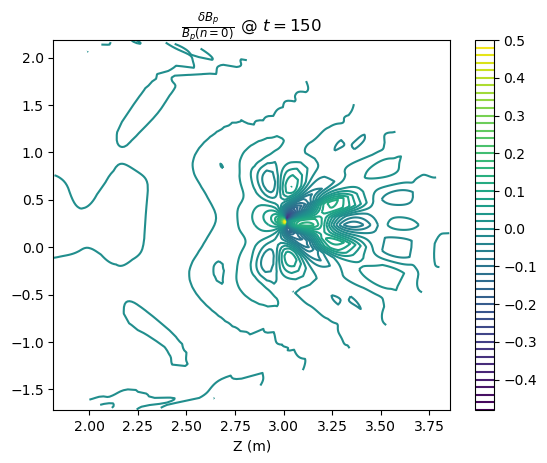

In [241]:
PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],dBp_ov_Bp,50)
PyPlot.title(L"$\frac{\delta B_p}{B_p (n=0)}\,\, @ \,\,t = 150$")
PyPlot.xlabel("R (m)")
PyPlot.xlabel("Z (m)")
PyPlot.colorbar()
PyPlot.show()

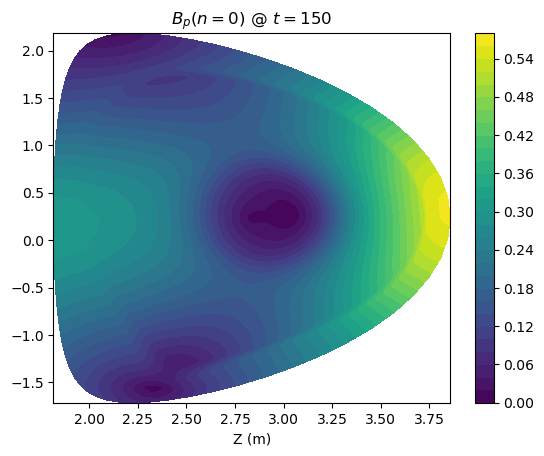

In [243]:
PyPlot.contourf(pxr.X[:,:,1],pxr.Z[:,:,1],JBpo[:,:,1],30)
PyPlot.title(L"$B_p (n=0)\,\, @ \,\,t = 150$")
PyPlot.xlabel("R (m)")
PyPlot.xlabel("Z (m)")
PyPlot.colorbar()
PyPlot.show()

High $\frac{\delta B_p}{B_p (n=0)}$ of the order of 20%-40%. For reference, the $\frac{\delta B^3}{B^3_{n=0}}$ is about 100 times smaller.